In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter # For tick formatting
import pickle
from numba import njit
from tqdm import tqdm, trange
from tqdm.notebook import tqdm, trange # For Jupyter notebooks

# =======================================================
# --- Functions ---
# =======================================================
def semicircle_pdf(x, radius=2):
    if np.abs(x) <= radius:
        return 2 * np.sqrt(radius**2 - x**2) / (radius**2 * np.pi)
    else:
        return 0


def sample_initial_conditions_semicircle_metropolis_hastings(N, radius=2, steps=1000, burn_in=100, proposal_std=0.5):
    X = np.zeros(N)
    x_current = 0  # Start at the center or a random point within [-radius, radius]

    # Burn-in phase
    for _ in range(burn_in):
        x_proposed = x_current + np.random.normal(0, proposal_std)
        if np.abs(x_proposed) > radius :
             pass # PDF will be 0, likely rejected if x_current is valid

        acceptance_ratio = 0
        pdf_current = semicircle_pdf(x_current, radius)
        if pdf_current > 0: # Avoid division by zero if x_current somehow became invalid
            pdf_proposed = semicircle_pdf(x_proposed, radius)
            acceptance_ratio = pdf_proposed / pdf_current
        
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposed

    # Sampling phase
    for i in range(N):
        for _ in range(steps): # Run M-H for a few steps to get less correlated samples
            x_proposed = x_current + np.random.normal(0, proposal_std)

            acceptance_ratio = 0
            pdf_current = semicircle_pdf(x_current, radius)
            if pdf_current > 0:
                pdf_proposed = semicircle_pdf(x_proposed, radius)
                acceptance_ratio = pdf_proposed / pdf_current

            if np.random.rand() < acceptance_ratio:
                x_current = x_proposed
        X[i] = x_current
        
    # Check distribution
    '''
    plt.hist(X, bins=50, density=True, label='Sampled Initial Conditions')
    x_vals = np.linspace(-radius, radius, 200)
    y_vals = [semicircle_pdf(x, radius) for x in x_vals]
    plt.plot(x_vals, y_vals, label='True Semicircle PDF (scaled)')
    plt.legend()
    plt.title("Initial Condition Distribution Check")
    plt.show()
    '''
    return X


@njit
def reference_step(X_ref, beta, tau):
    N = len(X_ref)
    X_new = np.zeros_like(X_ref)
    for i in range(N):
        interaction = 0
        for j in range(N):
            if i != j:
                diff = X_ref[i] - X_ref[j]
                interaction += diff / (1 + diff**2)
        drift = -beta * X_ref[i] + interaction / (N - 1)
        X_new[i] = X_ref[i] + tau * drift
    return X_new


def get_reference_X(X0, beta, T, K):
    tau = T / K
    X_ref = X0.copy()
    for k_step in trange(K, desc="Reference k_step", leave=False, dynamic_ncols=True): # Progress bar for reference steps
        X_ref = reference_step(X_ref, beta, tau)
    return X_ref


def get_rbm1_X(X0, beta, T, p, K):
    N = len(X0)
    X_rbm = np.copy(X0)
    tau = T / K

    for m in range(K):
        indices = np.random.permutation(N)
        
        X = np.copy(X_rbm)

        for i in range(0, N, p):
            batch_indices = indices[i : i + p]
            # Calculate drift for particles in this batch based on X_rbm (values at start of macro step)
            batch_drifts = np.zeros(p)
            X_batch = X_rbm[batch_indices]

            for i_idx, i in enumerate(batch_indices):
                current_drift = X_batch[i_idx]
                interaction_force = 0
                num_others = 0
                for j_idx, j in enumerate(batch_indices):
                    if i != j:
                        other_drift = X_batch[j_idx]
                        diff = current_drift - other_drift
                        interaction_force += diff / (1 + diff**2)
                        num_others += 1
                
                interaction_term = 0
                # Divisor is (p-1), i.e. num_others
                if num_others > 0:
                    interaction_term = (1 / num_others) * interaction_force
                
                batch_drifts[i_idx] = -beta * current_drift + interaction_term

            for i_idx, i in enumerate(batch_indices):
                X[i] = X_batch[i_idx] + batch_drifts[i_idx] * tau
        X_rbm = X
            
    return X_rbm


def calculate_rbm_error(X_rbm, X_ref):
    if len(X_rbm) != len(X_ref):
        raise ValueError("RBM and Reference solutions must have the same number of particles.")
    if len(X_rbm) == 0:
        return 0
    error_sq_sum = np.sum((X_rbm - X_ref)**2)
    return np.sqrt(error_sq_sum / len(X_rbm))


def calculate_forces_on_particles(X_positions, N_divisor, interaction_power=2):
    """
    Calculates the force F_n^i for all particles.
    F_n^i = (1/N_divisor) * sum_{j!=i} (X_n^i - X_n^j) / (1 + |X_n^i - X_n^j|^interaction_power)
    N_divisor is (N-1) for full system, (p-1) for RBM batch.
    """
    N = len(X_positions)
    forces = np.zeros(N)
    if N <= 1:
        return forces # No interaction force if N=0 or N=1

    for i in range(N):
        sum_interaction_kernel = 0.0
        for j in range(N):
            if i == j:
                continue
            diff = X_positions[i] - X_positions[j]
            # Denominator includes absolute value for robustness if diff can be complex,
            # but for 1D real numbers, diff**interaction_power is fine if power is even.
            # Using abs(diff)**interaction_power is safer for general k.
            # RBM paper uses |X_i - X_j|^3 in text for Eq 4.3, this is critical.
            # Let's make it a parameter.
            denominator = 1.0 + np.abs(diff)**interaction_power
            if denominator < 1e-9: # Avoid division by very small numbers, though 1+... should be fine
                sum_interaction_kernel += 0 # Or some large bounded force
            else:
                sum_interaction_kernel += diff / denominator
        
        if N_divisor > 0 : # N-1 or p-1
             forces[i] = sum_interaction_kernel / N_divisor
        # if N_divisor is 0 (e.g. p=1), force remains 0, handled by caller
            
    return forces

def solve_fully_coupled_verlet(X0_pos, V0_vel, T_final, K_steps, interaction_power_kernel=2, verbose=False):
    """
    Solves the second-order fully coupled system using Verlet integration.
    X_1 = X_0 + V_0*tau + 0.5*F_0*tau^2
    X_{n+1} = 2*X_n - X_{n-1} + F_n*tau^2
    """
    N = len(X0_pos)
    X_current = np.copy(X0_pos)
    V_current = np.copy(V0_vel) # Needed for the first step under this Verlet variant
    
    if K_steps == 0: return X_current
    tau = T_final / K_steps

    if N == 0: return X_current

    # First step requires V0
    # Calculate F0 (forces at time t=0 based on X0_pos)
    # Divisor for full system is N-1
    N_divisor_full = N - 1 if N > 1 else 1 # Avoid division by zero if N=1 (force is 0 anyway)

    F_current = calculate_forces_on_particles(X_current, N_divisor_full, interaction_power_kernel)
    X_previous = np.copy(X_current) # Store X0 as X_{n-1} for the first X_new calculation
    X_current = X_current + V_current * tau + 0.5 * F_current * tau**2 # This is X_1

    # Subsequent steps
    for k_step in range(1, K_steps): # k_step from 1 to K_steps-1 (total K_steps updates)
        F_current = calculate_forces_on_particles(X_current, N_divisor_full, interaction_power_kernel)
        X_new = 2 * X_current - X_previous + F_current * tau**2
        X_previous = np.copy(X_current)
        X_current = X_new
        
        if verbose and k_step % max(1, (K_steps // 10)) == 0:
            print(f"    Ref Verlet: Step {k_step}/{K_steps-1}")
            
    return X_current # Final positions

def solve_rbm1_verlet(X0_pos, V0_vel, T_final, p_batch_size, K_rbm_macro_steps, interaction_power_kernel=2, verbose=False):
    """
    Solves the second-order system using RBM-1 with Verlet integration.
    Each RBM macro step is one Verlet update of duration tau_rbm.
    """
    N = len(X0_pos)
    X_current_rbm = np.copy(X0_pos)
    V_current_rbm = np.copy(V0_vel) # Needed for the first RBM step

    if K_rbm_macro_steps == 0: return X_current_rbm
    tau_rbm = T_final / K_rbm_macro_steps
    
    if N == 0: return X_current_rbm
    if p_batch_size <= 1 and N > 1: # p=1 means no interaction within RBM step
        # Fallback to non-interacting Verlet if p=1
        X_previous_rbm_p1 = np.copy(X_current_rbm)
        X_current_rbm = X_current_rbm + V_current_rbm * tau_rbm # F=0 for first step
        for _ in range(1, K_rbm_macro_steps):
            X_new_p1 = 2 * X_current_rbm - X_previous_rbm_p1 # F=0
            X_previous_rbm_p1 = np.copy(X_current_rbm)
            X_current_rbm = X_new_p1
        return X_current_rbm


    # Calculate F0_rbm (forces at t=0 based on X0_pos using RBM batching)
    # This is subtle: F0 for the first step X_1 = X_0 + V_0*tau + 0.5*F_0*tau^2
    # should ideally use the RBM force.
    
    # RBM force calculation for a given X_state
    def get_rbm_forces(X_state_for_force_calc):
        forces_rbm = np.zeros(N)
        shuffled_indices = np.random.permutation(N)
        # Divisor for RBM batch is p_batch_size - 1
        N_divisor_rbm = p_batch_size - 1 if p_batch_size > 1 else 1

        for i_batch_start in range(0, N, p_batch_size):
            batch_orig_indices = shuffled_indices[i_batch_start : i_batch_start + p_batch_size]
            actual_p_in_batch = len(batch_orig_indices)
            if actual_p_in_batch <= 1: # Single particle in batch or empty
                for idx in batch_orig_indices: forces_rbm[idx] = 0.0 # No interaction force
                continue

            X_batch_vals = X_state_for_force_calc[batch_orig_indices]
            
            # Calculate forces for particles in this batch
            batch_member_forces = np.zeros(actual_p_in_batch)
            for i_in_batch, particle_orig_idx in enumerate(batch_orig_indices):
                sum_kernel_batch = 0.0
                for j_in_batch, other_particle_orig_idx in enumerate(batch_orig_indices):
                    if i_in_batch == j_in_batch:
                        continue
                    diff = X_batch_vals[i_in_batch] - X_batch_vals[j_in_batch]
                    denominator = 1.0 + np.abs(diff)**interaction_power_kernel
                    if denominator > 1e-9 : sum_kernel_batch += diff / denominator
                batch_member_forces[i_in_batch] = sum_kernel_batch / N_divisor_rbm
            
            # Assign calculated forces back to original particle indices
            for i_in_batch, particle_orig_idx in enumerate(batch_orig_indices):
                forces_rbm[particle_orig_idx] = batch_member_forces[i_in_batch]
        return forces_rbm

    F_current_rbm = get_rbm_forces(X_current_rbm)
    X_previous_rbm = np.copy(X_current_rbm)
    X_current_rbm = X_current_rbm + V_current_rbm * tau_rbm + 0.5 * F_current_rbm * tau_rbm**2

    # Subsequent RBM steps
    for m_step in range(1, K_rbm_macro_steps):
        F_current_rbm = get_rbm_forces(X_current_rbm) # Forces based on X at start of this macro step
        X_new_rbm = 2 * X_current_rbm - X_previous_rbm + F_current_rbm * tau_rbm**2
        X_previous_rbm = np.copy(X_current_rbm)
        X_current_rbm = X_new_rbm
        
        if verbose and m_step % max(1, (K_rbm_macro_steps // 10)) == 0:
            print(f"    RBM Verlet: Macro Step {m_step}/{K_rbm_macro_steps-1}")
            
    return X_current_rbm


'\ndef calculate_forces_on_particles(X_positions, N_divisor, interaction_power=2):\n    """\n    Calculates the force F_n^i for all particles.\n    F_n^i = (1/N_divisor) * sum_{j!=i} (X_n^i - X_n^j) / (1 + |X_n^i - X_n^j|^interaction_power)\n    N_divisor is (N-1) for full system, (p-1) for RBM batch.\n    """\n    N = len(X_positions)\n    forces = np.zeros(N)\n    if N <= 1:\n        return forces # No interaction force if N=0 or N=1\n\n    for i in range(N):\n        sum_interaction_kernel = 0.0\n        for j in range(N):\n            if i == j:\n                continue\n            diff = X_positions[i] - X_positions[j]\n            # Denominator includes absolute value for robustness if diff can be complex,\n            # but for 1D real numbers, diff**interaction_power is fine if power is even.\n            # Using abs(diff)**interaction_power is safer for general k.\n            # RBM paper uses |X_i - X_j|^3 in text for Eq 4.3, this is critical.\n            # Let\'s make it 

In [ ]:
# =======================================================
# --- Restoring Variables ---
# =======================================================
with open("RBM_variables.pkl", "rb") as f:
    restored = pickle.load(f)

globals().update(restored)

print("Variables restored")

# Figure 2

In [ ]:
# =======================================================
# --- Parameters ---
# =======================================================
T = 1
N_values = [50, 500, 2000]

p = 2
beta_values = [0, 1]

tau_powers = [-7, -6, -5, -4]
tau_values = [2**pow for pow in tau_powers]

K = 2**15
radius = 2.0

# Metropolis-Hastings parameters for initial condition sampling
steps = 1000 # Number of M-H steps to take for each particle after burn-in
burn_in = 100       # Initial M-H steps to discard
proposal_std = 0.5  # Proposal step size for M-H

# Averaging RBM Error
N_RBM_AVERAGE_RUNS = 1 # Number of RBM runs to average error over for smoother plots


# =======================================================
# --- Main Simulation Loop ---
# =======================================================
figure2_results = []
simulation_start_time = time.time()
np.random.seed(42)  # For reproducibility

for N in tqdm(N_values, desc="Loop over N", leave=False, dynamic_ncols=True):
    init_cond_time_start = time.time()
    X0 = sample_initial_conditions_semicircle_metropolis_hastings(
        N, radius, steps, burn_in, proposal_std
    )
    init_cond_time_end = time.time()
    print(f"  Initial conditions sampled. N={N}, Time: {init_cond_time_end - init_cond_time_start:.2f}s")

    for beta in tqdm(beta_values, desc=f"  beta-loop (N={N})", leave=False, dynamic_ncols=True):
        ref_start_time = time.time()
        X_ref = get_reference_X(X0, beta, T, K)
        ref_end_time = time.time()
        print(f"    Reference solution calculated. N={N}, Time: {ref_end_time - ref_start_time:.2f}s")

        for tau in tqdm(tau_values, desc=f"    tau-loop (N={N}, β={beta})", leave=False, dynamic_ncols=True):
            K_rbm = int(round(T / tau))

            errors = np.zeros(N_RBM_AVERAGE_RUNS)
            rbm_time = 0

            for i in range(N_RBM_AVERAGE_RUNS):
                rbm_start_time = time.time()
                X_rbm = get_rbm1_X(
                    X0, beta, T, p, K_rbm
                )
                rbm_end_time = time.time()
                rbm_time += (rbm_end_time - rbm_start_time)
                errors[i] = calculate_rbm_error(X_rbm, X_ref)

            avg_error = np.mean(errors)
            avg_rbm_time = rbm_time / N_RBM_AVERAGE_RUNS

            figure2_results.append({
                "N": N,
                "beta": beta,
                "tau": tau,
                "Error_E_hat": avg_error
            })

simulation_end_time = time.time()
print(f"\nTotal simulation time: {simulation_end_time - simulation_start_time:.2f} seconds.")

Loop over N:   0%|          | 0/3 [00:00<?, ?it/s]

  Initial conditions sampled. N=50, Time: 0.32s


  beta-loop (N=50):   0%|          | 0/2 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/32768 [00:00<?, ?it/s]

    Reference solution calculated. N=50, Time: 0.32s


    tau-loop (N=50, β=0):   0%|          | 0/4 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/32768 [00:00<?, ?it/s]

    Reference solution calculated. N=50, Time: 0.17s


    tau-loop (N=50, β=1):   0%|          | 0/4 [00:00<?, ?it/s]

  Initial conditions sampled. N=500, Time: 2.93s


  beta-loop (N=500):   0%|          | 0/2 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/32768 [00:00<?, ?it/s]

    Reference solution calculated. N=500, Time: 8.54s


    tau-loop (N=500, β=0):   0%|          | 0/4 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/32768 [00:00<?, ?it/s]

    Reference solution calculated. N=500, Time: 8.70s


    tau-loop (N=500, β=1):   0%|          | 0/4 [00:00<?, ?it/s]

  Initial conditions sampled. N=2000, Time: 11.94s


  beta-loop (N=2000):   0%|          | 0/2 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/32768 [00:00<?, ?it/s]

    Reference solution calculated. N=2000, Time: 133.12s


    tau-loop (N=2000, β=0):   0%|          | 0/4 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/32768 [00:00<?, ?it/s]

    Reference solution calculated. N=2000, Time: 135.47s


    tau-loop (N=2000, β=1):   0%|          | 0/4 [00:00<?, ?it/s]


Total simulation time: 306.67 seconds.



--- Results for Figure 2 Data Points (Averaged RBM Error) ---
   N  beta     tau Error_E_hat
  50     0 0.00781   3.846e-02
  50     0 0.01562   4.390e-02
  50     0 0.03125   6.829e-02
  50     0 0.06250   8.584e-02
  50     1 0.00781   1.539e-02
  50     1 0.01562   2.904e-02
  50     1 0.03125   3.991e-02
  50     1 0.06250   6.504e-02
 500     0 0.00781   3.113e-02
 500     0 0.01562   4.507e-02
 500     0 0.03125   6.405e-02
 500     0 0.06250   8.856e-02
 500     1 0.00781   2.018e-02
 500     1 0.01562   2.979e-02
 500     1 0.03125   4.148e-02
 500     1 0.06250   5.793e-02
2000     0 0.00781   3.227e-02
2000     0 0.01562   4.572e-02
2000     0 0.03125   6.278e-02
2000     0 0.06250   9.018e-02
2000     1 0.00781   2.121e-02
2000     1 0.01562   2.956e-02
2000     1 0.03125   4.130e-02
2000     1 0.06250   5.996e-02


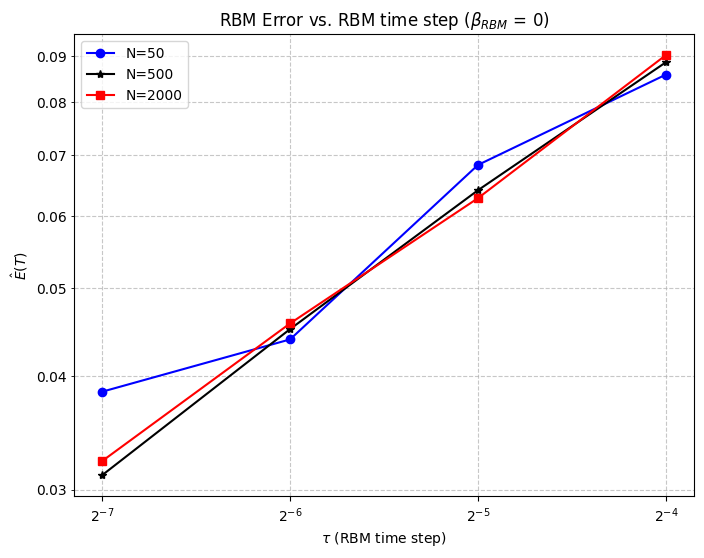

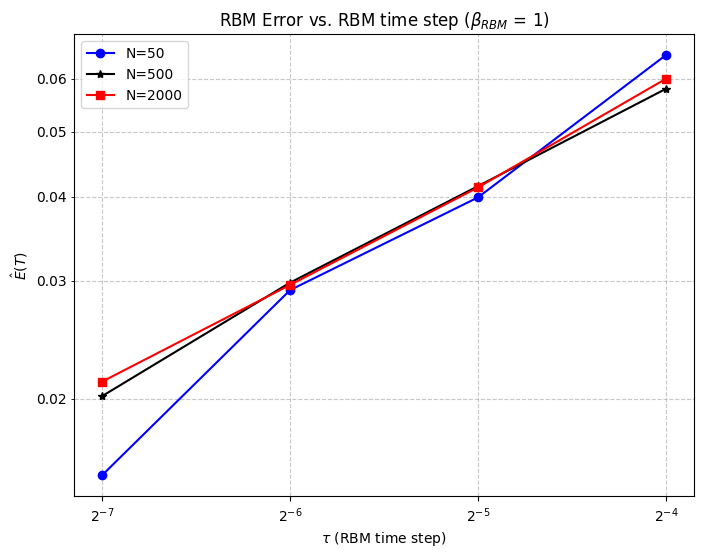

In [12]:
# =======================================================
# --- Display Results ---
# =======================================================
df_fig2_results = pd.DataFrame(figure2_results)
print("\n--- Results for Figure 2 Data Points (Averaged RBM Error) ---")
# Format for better readability
df_print_fig2 = df_fig2_results.copy()
df_print_fig2["tau"] = df_print_fig2["tau"].map('{:.5f}'.format)
df_print_fig2["Error_E_hat"] = df_print_fig2["Error_E_hat"].map('{:.3e}'.format)
print(df_print_fig2.to_string(index=False))


# =======================================================
# --- Plotting Figure 2 ---
# =======================================================
run_figure2 = True # Set to False to skip

if run_figure2:
    for b in df_fig2_results["beta"].unique():
        plt.figure(figsize=(8, 6))
        plot_beta = df_fig2_results[df_fig2_results["beta"] == b]
        
        # Define markers and colors as in the paper (approximate)
        markers = ['o', '*', 's'] # circle, star, square
        colors = ['blue', 'black', 'red'] # As per Fig 2 caption: N=50 blue circle, N=500 black star, N=2000 red square

        sorted_N = sorted(plot_beta["N"].unique())

        for i, n in enumerate(sorted_N):
            plot_N = plot_beta[plot_beta["N"] == n]
            # Sort by tau for consistent plotting lines
            plot_N = plot_N.sort_values(by="tau")
            plt.plot(plot_N["tau"], plot_N["Error_E_hat"], 
                     marker=markers[i % len(markers)], 
                     color=colors[i % len(colors)],
                     linestyle='-', 
                     label=f'N={n}')
        
        plt.xscale('log', base=2)
        plt.yscale('log')
        plt.xlabel(r'$\tau$ (RBM time step)') # Using tau as in paper's Fig 2
        plt.ylabel(r'$\hat{E}(T)$')
        plt.title(f'RBM Error vs. RBM time step ($\\beta_{{RBM}}$ = {b})')
        plt.legend()
        plt.grid(True, which="both", ls="--", alpha=0.7)
        plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}')) # 2 decimal places
        plt.gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2f")) # 2 decimal places for minor ticks
      
        sorted_tau = sorted(list(df_fig2_results["tau"].unique()))
        xtick_labels_powers = [int(np.log2(val)) for val in sorted_tau]
        xtick_labels = [f'$2^{{{pow}}}$' for pow in xtick_labels_powers]
        plt.xticks(sorted_tau, xtick_labels)
        plt.show()

# Figure 3

In [20]:
# =======================================================
# --- Parameters ---
# =======================================================
N_fig3 = 500
beta_values_fig3 = [0, 1]
tau_rbm_fig3 = 2**-7
T_values_fig3 = [1, 2, 4, 8, 16]
tau_ref_fig3 = 2**-15


figure3_results_list = []
fig3_total_start_time = time.time() # Total time start

init_cond_time_start_fig3 = time.time()
X0_fig3 = sample_initial_conditions_semicircle_metropolis_hastings(
    N_fig3, radius, steps, burn_in, proposal_std
)
init_cond_time_end_fig3 = time.time()
print(f"Initial conditions sampled. Time: {init_cond_time_end_fig3 - init_cond_time_start_fig3:.2f}s")

for beta_fig3 in tqdm(beta_values_fig3, desc=f"  beta-loop (N={N_fig3})", leave=False, dynamic_ncols=True):
    for T_fig3 in tqdm(T_values_fig3, desc=f"    T-loop (N={N_fig3}, β={beta_fig3})", leave=False, dynamic_ncols=True):
        print(f"\nRunning for T={T_fig3}")
        K_ref_fig3 = int(round(T_fig3 / tau_ref_fig3))
        K_rbm_fig3 = int(round(T_fig3 / tau_rbm_fig3))

        ref_start_time_fig3 = time.time()
        X_ref_fig3 = get_reference_X(
            X0_fig3, beta_fig3, T_fig3, K_ref_fig3
        )
        ref_end_time_fig3 = time.time()
        print(f"    Reference solution calculated. Time: {ref_end_time_fig3 - ref_start_time_fig3:.2f}s")
        
        errors_fig3 = np.zeros(N_RBM_AVERAGE_RUNS)
        rbm_time_fig3 = 0
        for i in range(N_RBM_AVERAGE_RUNS):
            rbm_start_time_fig3 = time.time()
            X_rbm_fig3 = get_rbm1_X(
                X0_fig3, beta_fig3, T_fig3, p, K_rbm_fig3
            )
            rbm_end_time_fig3 = time.time()
            rbm_time_fig3 += (rbm_end_time_fig3 - rbm_start_time_fig3)
            errors_fig3[i] = calculate_rbm_error(X_rbm_fig3, X_ref_fig3)
        avg_error_fig3 = np.mean(errors_fig3)
        avg_rbm_time_fig3 = rbm_time_fig3 / N_RBM_AVERAGE_RUNS
        print(f"    RBM solutions calculated. Avg RBM Time: {avg_rbm_time_fig3:.2f}s/run")
        
        figure3_results_list.append({
            "N": N_fig3, "beta": beta_fig3, "T": T_fig3, "Error_E_hat": avg_error_fig3
        })
        print(f"    Avg_Error_E_hat={avg_error_fig3:.3e}")
        
df_fig3_results = pd.DataFrame(figure3_results_list)
print("\n--- Error for RBM-1 versus time ---")
print(df_fig3_results.to_string(index=False))
fig3_total_end_time = time.time()
print(f"Total Time: {fig3_total_end_time - fig3_total_start_time:.2f}s")

Initial conditions sampled. Time: 3.33s


  beta-loop (N=500):   0%|          | 0/2 [00:00<?, ?it/s]

    T-loop (N=500, β=0):   0%|          | 0/5 [00:00<?, ?it/s]


Running for T=1


Reference k_step:   0%|          | 0/32768 [00:00<?, ?it/s]

    Reference solution calculated. Time: 8.85s
    RBM solutions calculated. Avg RBM Time: 0.33s/run
    Avg_Error_E_hat=3.190e-02

Running for T=2


Reference k_step:   0%|          | 0/65536 [00:00<?, ?it/s]

    Reference solution calculated. Time: 17.65s
    RBM solutions calculated. Avg RBM Time: 0.59s/run
    Avg_Error_E_hat=4.813e-02

Running for T=4


Reference k_step:   0%|          | 0/131072 [00:00<?, ?it/s]

    Reference solution calculated. Time: 33.94s
    RBM solutions calculated. Avg RBM Time: 1.03s/run
    Avg_Error_E_hat=8.005e-02

Running for T=8


Reference k_step:   0%|          | 0/262144 [00:00<?, ?it/s]

    Reference solution calculated. Time: 67.24s
    RBM solutions calculated. Avg RBM Time: 2.18s/run
    Avg_Error_E_hat=1.128e-01

Running for T=16


Reference k_step:   0%|          | 0/524288 [00:00<?, ?it/s]

    Reference solution calculated. Time: 133.47s
    RBM solutions calculated. Avg RBM Time: 4.33s/run
    Avg_Error_E_hat=1.909e-01


    T-loop (N=500, β=1):   0%|          | 0/5 [00:00<?, ?it/s]


Running for T=1


Reference k_step:   0%|          | 0/32768 [00:00<?, ?it/s]

    Reference solution calculated. Time: 8.50s
    RBM solutions calculated. Avg RBM Time: 0.27s/run
    Avg_Error_E_hat=2.062e-02

Running for T=2


Reference k_step:   0%|          | 0/65536 [00:00<?, ?it/s]

    Reference solution calculated. Time: 16.68s
    RBM solutions calculated. Avg RBM Time: 0.59s/run
    Avg_Error_E_hat=2.340e-02

Running for T=4


Reference k_step:   0%|          | 0/131072 [00:00<?, ?it/s]

    Reference solution calculated. Time: 33.37s
    RBM solutions calculated. Avg RBM Time: 1.15s/run
    Avg_Error_E_hat=2.443e-02

Running for T=8


Reference k_step:   0%|          | 0/262144 [00:00<?, ?it/s]

    Reference solution calculated. Time: 66.77s
    RBM solutions calculated. Avg RBM Time: 2.23s/run
    Avg_Error_E_hat=2.755e-02

Running for T=16


Reference k_step:   0%|          | 0/524288 [00:00<?, ?it/s]

    Reference solution calculated. Time: 133.76s
    RBM solutions calculated. Avg RBM Time: 4.12s/run
    Avg_Error_E_hat=2.851e-02

--- Error for RBM-1 versus time ---
  N  beta  T  Error_E_hat
500     0  1     0.031902
500     0  2     0.048132
500     0  4     0.080050
500     0  8     0.112842
500     0 16     0.190859
500     1  1     0.020621
500     1  2     0.023398
500     1  4     0.024435
500     1  8     0.027555
500     1 16     0.028506
Total Time: 540.42s


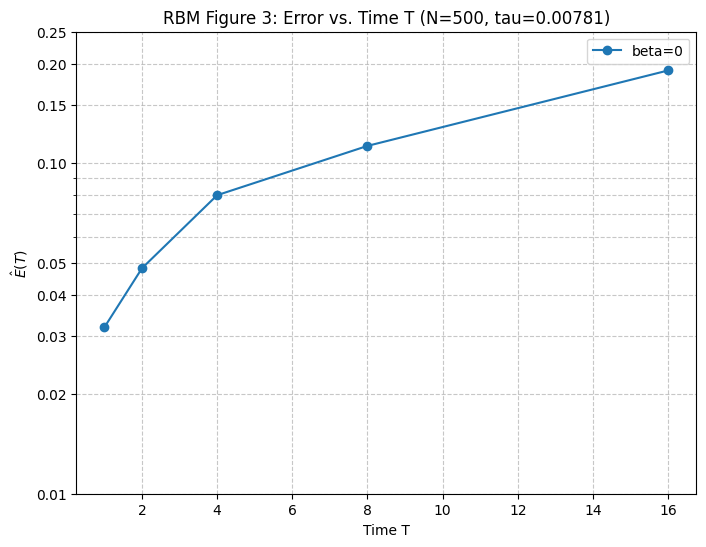

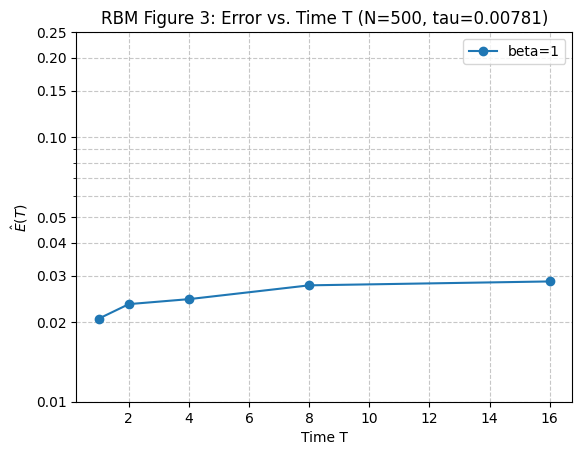

In [ ]:
# =======================================================
# Plotting for Figure 3
# =======================================================
plt.figure(figsize=(8, 6))
for b in df_fig3_results["beta"].unique():
    plot_beta = df_fig3_results[df_fig3_results["beta"] == b]
    plt.plot(plot_beta["T"], plot_beta["Error_E_hat"], marker='o', linestyle='-', label=f'beta={b}')
    plt.xlabel('Time T')
    plt.ylabel(r'$\hat{E}(T)$')
    plt.title(f'RBM Figure 3: Error vs. Time T (N={N_fig3}, tau={tau_rbm_fig3:.5f})')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.yscale('log')
    plt.yticks([0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25])
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}')) # 2 decimal places
    plt.show()

In [23]:
# =======================================================
# --- Plotting Figure 4 ---
# =======================================================
N_values_fig4 = [100, 1000, 10000] 
beta_fig4 = 1
T_fig4 = 1
K_ref_fig4 = 2**15
K_powers_fig4 = [6, 5, 4, 3, 2, 1]
K_values_fig4 = [2**pow for pow in K_powers_fig4] # Direct computation K values
N_RBM_AVERAGE_RUNS = 1


figure4_results_list = []
fig4_total_start_time = time.time()

for N_fig4 in tqdm(N_values_fig4, desc="Loop over N", leave=False, dynamic_ncols=True):
    init_cond_time_start_fig4 = time.time()
    X0_fig4 = sample_initial_conditions_semicircle_metropolis_hastings(
        N_fig4, radius, steps, burn_in, proposal_std
    )
    init_cond_time_end_fig4 = time.time()
    print(f"Initial conditions sampled. Time: {init_cond_time_end_fig4 - init_cond_time_start_fig4:.2f}s")

    ref_start_time_fig4 = time.time()
    X_ref_fig4 = get_reference_X(
        X0_fig4, beta_fig4, T_fig4, K_ref_fig4
    )
    ref_end_time_fig4 = time.time()
    print(f"High-Accuracy Reference Done. Time: {ref_end_time_fig4 - ref_start_time_fig4:.2f}s")
    
    # Generate data for Figure 4
    for K_fig4 in tqdm(K_values_fig4, desc=f"  K-Loop (N={N_fig4})", leave=False, dynamic_ncols=True):
        tau_fig4 = T_fig4 / K_fig4

        # Direct solution
        direct_start_time = time.time()
        X_direct = get_reference_X(
            X0_fig4, beta_fig4, T_fig4, K_fig4
        )
        direct_end_time = time.time()
        cpu_time_direct = direct_end_time - direct_start_time
        error_direct = calculate_rbm_error(X_direct, X_ref_fig4)
        
        figure4_results_list.append({
            "Method": "Direct", "N": N_fig4, "beta": beta_fig4, 
            "Steps_or_Tau": K_fig4, # Storing K_micro_steps here
            "CPU_Time_s": cpu_time_direct, "Error_E_hat": error_direct
        })

        # RBM-1
        errors_fig4 = np.zeros(N_RBM_AVERAGE_RUNS)
        cpu_times_rbm = np.zeros(N_RBM_AVERAGE_RUNS)

        for i in range(N_RBM_AVERAGE_RUNS):
            rbm_start_time = time.time()
            X_rbm_fig4 = get_rbm1_X(
                X0_fig4, beta_fig4, T_fig4, p, K_fig4
            )
            rbm_end_time = time.time()
            cpu_times_rbm[i] = rbm_end_time - rbm_start_time
            errors_fig4[i] = calculate_rbm_error(X_rbm_fig4, X_ref_fig4)
        
        avg_error_rbm_fig4 = np.mean(errors_fig4)
        avg_cpu_time_rbm = np.mean(cpu_times_rbm)
        
        figure4_results_list.append({
            "Method": "RBM-1", "N": N_fig4, "beta": beta_fig4,
            "Steps_or_Tau": K_fig4, # Storing tau here
            "CPU_Time_s": avg_cpu_time_rbm, "Error_E_hat": avg_error_rbm_fig4
        })
df_fig4_results = pd.DataFrame(figure4_results_list)
print("\n--- Fig4 Results (Error vs. CPU Time) ---")
print(df_fig4_results.to_string(index=False))
fig4_total_end_time = time.time()
print(f"Fig4 Total Time: {fig4_total_end_time - fig4_total_start_time:.2f}s")

Loop over N:   0%|          | 0/3 [00:00<?, ?it/s]

Initial conditions sampled. Time: 0.63s


Reference k_step:   0%|          | 0/32768 [00:00<?, ?it/s]

High-Accuracy Reference Done. Time: 0.44s


  K-Loop (N=100):   0%|          | 0/6 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/64 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/32 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/16 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/8 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/4 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/2 [00:00<?, ?it/s]

Initial conditions sampled. Time: 6.09s


Reference k_step:   0%|          | 0/32768 [00:00<?, ?it/s]

High-Accuracy Reference Done. Time: 32.73s


  K-Loop (N=1000):   0%|          | 0/6 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/64 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/32 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/16 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/8 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/4 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/2 [00:00<?, ?it/s]

Initial conditions sampled. Time: 59.29s


Reference k_step:   0%|          | 0/32768 [00:00<?, ?it/s]

High-Accuracy Reference Done. Time: 3278.21s


  K-Loop (N=10000):   0%|          | 0/6 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/64 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/32 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/16 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/8 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/4 [00:00<?, ?it/s]

Reference k_step:   0%|          | 0/2 [00:00<?, ?it/s]


--- Fig4 Results (Error vs. CPU Time) ---
Method     N  beta  Steps_or_Tau  CPU_Time_s  Error_E_hat
Direct   100     1            64    0.008797     0.002464
 RBM-1   100     1            64    0.032332     0.032401
Direct   100     1            32    0.009974     0.004965
 RBM-1   100     1            32    0.024122     0.042045
Direct   100     1            16    0.006980     0.010072
 RBM-1   100     1            16    0.011543     0.059166
Direct   100     1             8    0.008302     0.020722
 RBM-1   100     1             8    0.003989     0.088500
Direct   100     1             4    0.007978     0.044004
 RBM-1   100     1             4    0.001015     0.123859
Direct   100     1             2    0.008733     0.101108
 RBM-1   100     1             2    0.000997     0.202437
Direct  1000     1            64    0.081318     0.002193
 RBM-1  1000     1            64    0.287891     0.029924
Direct  1000     1            32    0.047632     0.004420
 RBM-1  1000     1           

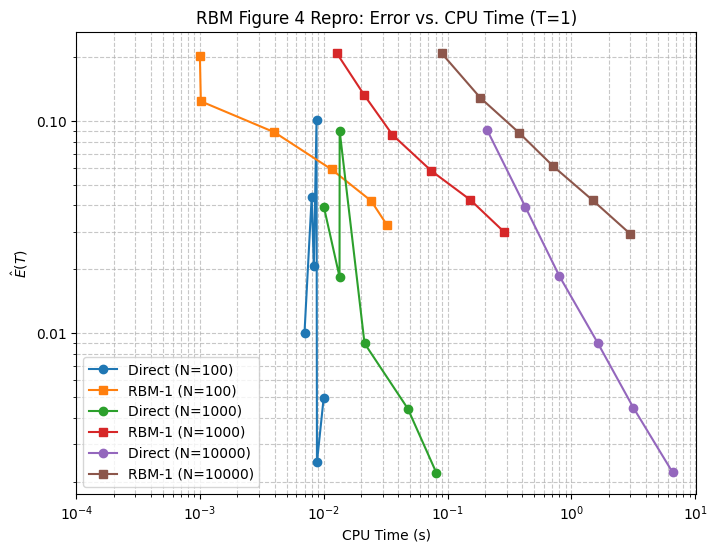

In [24]:
# Plotting for Figure 4
plt.figure(figsize=(8, 6))
methods = df_fig4_results["Method"].unique()
markers_fig4 = ['o', 's', '^'] # Different markers for different methods/N values

for N_fig4 in N_values_fig4:
    for i, method in enumerate(methods):
        subset_method = df_fig4_results[(df_fig4_results["Method"] == method) & (df_fig4_results["N"] == N_fig4)]
        # Sort by CPU_Time_s for consistent plotting lines
        subset_method = subset_method.sort_values(by="CPU_Time_s")
        plt.plot(subset_method["CPU_Time_s"], subset_method["Error_E_hat"], 
                    marker=markers_fig4[i % len(markers_fig4)], 
                    linestyle='-', 
                    label=f'{method} (N={N_fig4})')

plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
plt.xlabel('CPU Time (s)')
plt.ylabel(r'$\hat{E}(T)$')
plt.title(f'RBM Figure 4 Repro: Error vs. CPU Time (T={T_fig4})')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}')) # 2 decimal places
plt.show()

In [ ]:
# =======================================================
# --- Saving Variables ---
# =======================================================
import pickle

# Safely filter out unpicklable or irrelevant entries
def is_picklable(obj):
    try:
        pickle.dumps(obj)
        return True
    except Exception:
        return False

to_save = {
    k: v for k, v in globals().items()
    if not k.startswith("__") and k not in ["pickle", "is_picklable"]
    and is_picklable(v)
}

with open("RBM_variables.pkl", "wb") as f:
    pickle.dump(to_save, f)

print("Variables saved to RBM_variables.pkl")


✅ Only picklable variables saved to my_session.pkl


In [ ]:
# =======================================================
# --- Parameters for RBM Figure 5 ---
# =======================================================
T_fig5 = 1.0
N_values_fig5 = [50, 100] # Reduced for quicker testing
p_fig5 = 2

# Interaction kernel power in denominator: |X_i - X_j|^k
INTERACTION_POWER_FIG5 = 2 # k

# Tau_RBM values (macro RBM time step for Verlet)
# Fig 5 x-axis goes from 2^-9 to 2^-4
tau_powers_fig5 = list(range(-9, -4 + 1)) # -9, -8, -7, -6, -5, -4
tau_values_fig5 = [2**pow for pow in tau_powers_fig5]

# Reference solution parameters for Verlet
K_ref_fig5 = 2**15

# Initial condition generation
radius_fig5 = 2.0 # For positions
V0_std_fig5 = 1.0      # For initial velocities V0 ~ N(0,1) -> StdDev is 1.0

# Averaging RBM Error
N_RBM_AVERAGE_RUNS_FIG5 = 1 # Use average for smoother plot


# =======================================================
# --- Main Simulation Loop for RBM Figure 5 ---
# =======================================================

print("\n\n=== GENERATING DATA FOR FIGURE 5: Error vs. RBM time step (2nd Order System) ===")
figure5_results_list = []
fig5_total_start_time = time.time()
np.random.seed(123) # Different seed for this figure if desired

verbose_main_loops_fig5 = True

for N_fig5 in N_values_fig5:
    if verbose_main_loops_fig5: print(f"\nFig5: N = {N_fig5} particles...")
    
    X0_pos_fig5 = sample_initial_conditions_semicircle_metropolis_hastings(
        N_fig5, radius_fig5, steps, burn_in, proposal_std, verbose_mh=(N_fig5 < 200)
    )
    V0_vel_fig5 = np.random.normal(0, V0_std_fig5, N_fig5)
    
    if verbose_main_loops_fig5: print(f"  Fig5: Calculating Reference Solution (N={N_fig5}, K_ref={K_ref_fig5})...")
    ref_start_time_fig5 = time.time()
    X_ref_at_T_fig5 = solve_fully_coupled_verlet(
        X0_pos_fig5, V0_vel_fig5, T_fig5, K_ref_fig5, 
        interaction_power_kernel=INTERACTION_POWER_FIG5, verbose=(K_ref_fig5 > 10000 and N_fig5 < 200)
    )
    ref_end_time_fig5 = time.time()
    if verbose_main_loops_fig5: print(f"  Fig5: Reference solution calculated. Time: {ref_end_time_fig5 - ref_start_time_fig5:.2f}s")

    for tau_rbm_fig5_val in tau_values_fig5:
        K_rbm_fig5_val = int(round(T_fig5 / tau_rbm_fig5_val))
        if verbose_main_loops_fig5: print(f"    Fig5: tau_RBM = {tau_rbm_fig5_val:.5f} (K_RBM = {K_rbm_fig5_val}), AvgRuns={N_RBM_AVERAGE_RUNS_FIG5}")
        
        errors_current_tau_fig5 = np.zeros(N_RBM_AVERAGE_RUNS_FIG5)
        for rbm_run_idx in range(N_RBM_AVERAGE_RUNS_FIG5):
            # RBM starts from the SAME X0, V0 for each averaging run
            X_rbm_at_T_one_run_fig5 = solve_rbm1_verlet(
                X0_pos_fig5, V0_vel_fig5, T_fig5, p_fig5, 
                K_rbm_fig5_val, interaction_power_kernel=INTERACTION_POWER_FIG5, verbose=False
            )
            errors_current_tau_fig5[rbm_run_idx] = calculate_rbm_error(X_rbm_at_T_one_run_fig5, X_ref_at_T_fig5)
        
        avg_error_fig5 = np.mean(errors_current_tau_fig5)
        
        figure5_results_list.append({
            "N": N_fig5, 
            "tau_RBM": tau_rbm_fig5_val, 
            "Error_E_hat": avg_error_fig5
        })
        if verbose_main_loops_fig5: print(f"      Fig5: N={N_fig5}, tau_RBM={tau_rbm_fig5_val:.5f}, Avg_Error_E_hat={avg_error_fig5:.3e}")

df_fig5_results = pd.DataFrame(figure5_results_list)
print("\n--- Fig5 Results (Error vs. tau_RBM for 2nd Order System) ---")
df_print_fig5 = df_fig5_results.copy()
df_print_fig5["tau_RBM"] = df_print_fig5["tau_RBM"].map('{:.5f}'.format)
df_print_fig5["Error_E_hat"] = df_print_fig5["Error_E_hat"].map('{:.3e}'.format)
print(df_print_fig5.to_string(index=False))
fig5_total_end_time = time.time()
if verbose_main_loops_fig5: print(f"Fig5 Total Time: {fig5_total_end_time - fig5_total_start_time:.2f}s")

# --- Plotting for Figure 5 ---
plt.figure(figsize=(8, 6))
markers_fig5 = ['o', '*', 's'] 
colors_fig5 = ['blue', 'red', 'green'] # Adjusted colors for visibility
                                        # RBM Paper Fig 5: N=50 blue star, N=500 red circle, N=2000 green diamond

unique_N_sorted_fig5 = sorted(df_fig5_results["N"].unique())

for i, N_val_plot in enumerate(unique_N_sorted_fig5):
    subset_N = df_fig5_results[df_fig5_results["N"] == N_val_plot].sort_values(by="tau_RBM")
    # Match paper's marker style if possible
    marker_style = '*' if N_val_plot == 50 else ('o' if N_val_plot == 500 else 'D') # D for diamond
    color_style = 'blue' if N_val_plot == 50 else ('red' if N_val_plot == 500 else 'green')

    plt.plot(subset_N["tau_RBM"], subset_N["Error_E_hat"], 
                marker=marker_style, # Use marker_style based on N
                color=color_style,   # Use color_style based on N
                linestyle='-', 
                label=f'N={N_val_plot}')

# Add reference line E = 0.2 * tau^0.5
if tau_values_fig5: # Check if list is not empty
    tau_ref_line = np.array(sorted(tau_values_fig5))
    error_ref_line = 0.2 * np.sqrt(tau_ref_line)
    plt.plot(tau_ref_line, error_ref_line, color='black', linestyle='--', label=r'$E=0.2\tau^{1/2}$')

plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel(r'$\tau$ (RBM time step)')
plt.ylabel(r'$\hat{E}(T)$')
plt.title(f'RBM Figure 5 Repro: Error vs. RBM time step (2nd Order System)')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.7)

# X-axis ticks for powers of 2
# Ensure tau_values_fig5 is sorted for correct tick placement
sorted_tau_fig5 = sorted(list(df_fig5_results["tau_RBM"].unique()))
if sorted_tau_fig5: # Check if not empty
    xtick_labels_powers_fig5 = [int(np.log2(val)) for val in sorted_tau_fig5]
    xtick_labels_fig5 = [f'$2^{{{pow}}}$' for pow in xtick_labels_powers_fig5]
    plt.xticks(sorted_tau_fig5, xtick_labels_fig5)

plt.show()